In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-07 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt

# Load datasets

In [3]:
datasets = pd.DataFrame()
for i in range(1,5):
    print(i)
    dump = pd.read_csv("../../data/sample ({}).csv".format(i), engine='python',names=['chat','label'])
    datasets = pd.concat([datasets, dump])
datasets.head()

1
2
3
4


,chat,label
0,자기잘못인거알면 중고딩도 먼저사과하는걸아는데,0
1,싹둑이 채팅창 관리 중입니다,0
2,싹둑이 채팅창 관리 중입니다,0
3,어제 어글 아직도 가? 개인적으로 사과하셨대 그만해 칭구들앙,0
4,케읍이 뭔데요 무슨사건있엇음?,0


In [4]:
datasets.reset_index(drop=True,inplace=True)

In [5]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
chat     3500 non-null object
label    3500 non-null int64
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


In [6]:
datasets.label = datasets.label.astype('int')

In [7]:
len(datasets[datasets.label ==1])/ len(datasets[datasets.label ==0]) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ

0.16163292399601725

# Tokenize
## 형태소분석

In [8]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
morped = [morp.pos(_, norm=True, join=True) for _ in tqdm(datasets.chat)] # Stemming은 하지 않는다.

100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:22<00:00, 152.80it/s]


In [10]:
morped[:5]

[['자기/Noun',
  '잘못/Noun',
  '인거/Josa',
  '알/Noun',
  '면/Josa',
  '중/Noun',
  '고딩/Noun',
  '도/Josa',
  '먼저/Noun',
  '사과/Noun',
  '하/Suffix',
  '는/Josa',
  '걸아는데/Verb'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['어제/Noun',
  '어글/Noun',
  '아직도/Adverb',
  '가/Verb',
  '?/Punctuation',
  '개인/Noun',
  '적/Suffix',
  '으로/Josa',
  '사과/Noun',
  '하셨대/Verb',
  '그만해/Adjective',
  '칭구들앙/Noun'],
 ['케읍/Noun',
  '이/Josa',
  '뭔/Modifier',
  '데/Noun',
  '요/Josa',
  '무슨/Modifier',
  '사건/Noun',
  '있/Adjective',
  '엇음/Noun',
  '?/Punctuation']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [11]:
vocab_size = 5000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
형/Suffix :  724
이/Josa :  706
샤/Noun :  587
나왔/Verb :  562
브베/Noun :  442
창/Noun :  420
채팅/Noun :  417
중/Noun :  408
입니다/Adjective :  408
싹둑/Noun :  407

단어 사전:
0 <PAD>
1 <OOV>
2 형/Suffix
3 이/Josa
4 샤/Noun
5 나왔/Verb
6 브베/Noun
7 창/Noun
8 채팅/Noun
9 중/Noun

단어 사전 크기:  3421


In [12]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['자기/Noun', '잘못/Noun', '인거/Josa', '알/Noun', '면/Josa', '중/Noun', '고딩/Noun', '도/Josa', '먼저/Noun', '사과/Noun', '하/Suffix', '는/Josa', '걸아는데/Verb']
문자 -> 숫자:  [234, 781, 782, 381, 293, 9, 1292, 58, 1293, 235, 93, 60, 1294]
숫자 -> 문자:  자기/Noun 잘못/Noun 인거/Josa 알/Noun 면/Josa 중/Noun 고딩/Noun 도/Josa 먼저/Noun 사과/Noun 하/Suffix 는/Josa 걸아는데/Verb


# Padding

In [13]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 20
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

# Data Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

print("train_inputs shape: ", X_train.shape)
print("test_inputs shape: ", X_test.shape)
print("train_labels shape: ", y_train.shape)
print("test_labels shape: ", y_test.shape)

train_inputs shape:  (2625, 20)
test_inputs shape:  (875, 20)
train_labels shape:  (2625,)
test_labels shape:  (875,)


# Model

In [15]:
import warnings
warnings.filterwarnings(action='once')

In [16]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

def eval_model(model):
    test_loss, test_acc = model.evaluate(X_test, pd.get_dummies(y_test))
    print('Test accuracy:', test_acc)

Train on 2625 samples, validate on 875 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
2625/2625 [==============================] - ETA: 2:53 - loss: 0.6927 - acc: 0.500 - ETA: 33s - loss: 0.6846 - acc: 0.653 - ETA: 20s - loss: 0.6804 - acc: 0.67 - ETA: 14s - loss: 0.6747 - acc: 0.70 - ETA: 11s - loss: 0.6718 - acc: 0.71 - ETA: 9s - loss: 0.6670 - acc: 0.7252 - ETA: 7s - loss: 0.6606 - acc: 0.737 - ETA: 6s - loss: 0.6516 - acc: 0.754 - ETA: 5s - loss: 0.6407 - acc: 0.766 - ETA: 4s - loss: 0.6301 - acc: 0.772 - ETA: 4s - loss: 0.6242 - acc: 0.776 - ETA: 3s - loss: 0.6156 - acc: 0.782 - ETA: 3s - loss: 0.6027 - acc: 0.790 - ETA: 2s - loss: 0.5833 - acc: 0.800 - ETA: 2s - loss: 0.5797 - acc: 0.801 - ETA: 1s - loss: 0.5766 - acc: 0.799 - ETA: 1s - loss: 0.5585 - acc: 0.807 - ETA: 1s - loss: 0.5512 - acc: 0.810 - ETA: 1s - loss: 0.5404 - acc: 0.814 - ETA: 0s - loss: 0.5350 - acc: 0.816 - ETA: 0s 

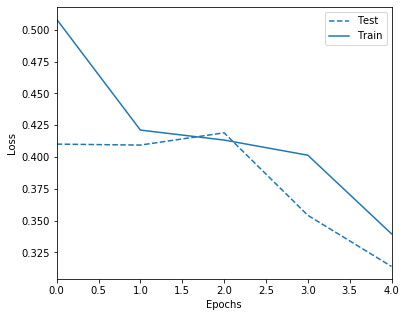

In [18]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
          pd.get_dummies(y_train),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
eval_model(model)

In [19]:
set(model.predict_classes(X_test)) ## 전부 0으로 예측을 함 . 데이터 편향 문제때문

{0}

In [20]:
# result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
# result['predict'] = model.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
# result[result.predict>0.3]


# 데이터 클래스 불균형 문제 해결하자

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## upsampling

In [22]:
up_X, up_y = RandomOverSampler().fit_resample(x_padded, datasets.label)
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y)

In [23]:
# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(6026, 3013)

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 4519 samples, validate on 1507 samples
Epoch 1/5
4519/4519 [==============================] - ETA: 3:39 - loss: 0.7382 - acc: 0.531 - ETA: 30s - loss: 0.7253 - acc: 0.491 - ETA: 18s - loss: 0.6773 - acc: 0.48 - ETA: 11s - loss: 0.6568 - acc: 0.50 - ETA: 8s - loss: 0.6452 - acc: 0.4909 - ETA: 7s - loss: 0.6219 - acc: 0.508 - ETA: 6s - loss: 0.6177 - acc: 0.505 - ETA: 5s - loss: 0.6131 - acc: 0.500 - ETA: 4s - loss: 0.6046 - acc: 0.500 - ETA: 3s - loss: 0.6010 - acc: 0.497 - ETA: 3s - loss: 0.5979 - acc: 0.503 - ETA: 3s - loss: 0.5928 - acc: 0.512 - ETA: 2s - loss: 0.5898 - acc: 0.521 - ETA: 2s - loss: 0.5855 - acc: 0.536 - ETA: 2s - loss: 0.5805 - acc: 0.547 - ETA: 1s - loss: 0.5766 - acc: 0.562 - ETA: 1s - loss: 0.5731 - acc: 0.572 - ETA: 1s - loss: 0.5690 - acc: 0.585 - ETA: 1s - loss: 0.5668 - acc: 0.596 - ETA: 1s - loss: 0.5623 - acc: 0.605 - ETA: 0s - loss: 0.5596 - acc: 0.614 - ETA: 0s - loss: 0.5562 - acc: 0.624 - ETA: 0s - loss: 0.5528 - acc: 0.631 - ETA: 0s - loss: 0.5

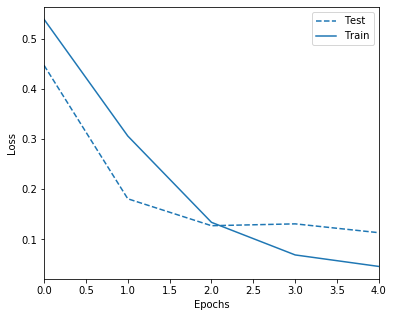

In [24]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(up_X_train,
          pd.get_dummies(up_y_train),
          epochs=5,
          validation_data=(up_X_test, pd.get_dummies(up_y_test))
         )
plot_loss(history)
test_loss, test_acc = model.evaluate(up_X_test, pd.get_dummies(up_y_test))
print('Test accuracy:', test_acc)

In [25]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, up_X_test))
result['predict'] = model.predict_proba(up_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)

전체채팅수1507, 유해채팅수809


,0,predict
1,하/Exclamation 비스트/Noun 좀/Noun 그만/Adverb 쳐/Verb...,0.999835
2,정신병/Noun 자/Suffix 새끼/Noun <PAD> <PAD> <PAD> <P...,0.998871
3,핡/Noun <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA...,0.944404
5,아이작/Noun 확장/Noun 판/Noun 재밌냐/Adjective <PAD> <P...,0.819586
6,창석/Noun 이부/Noun 랄/Noun 냄새/Noun 맞고/Verb 싣/Verb ...,0.999873
10,아/Exclamation 개패/Noun 고/Josa 싶다/Verb ㄱ/KoreanP...,0.998358
11,창석/Noun 이/Determiner 붕알/Noun 냄새/Noun 맞고/Verb 파...,0.999441
12,미애/Noun 가/Josa 치워주나/Verb 보지/Noun 씨발/Noun 년/Nou...,0.999990
16,ㄴ/KoreanParticle ㅈ/KoreanParticle <PAD> <PAD> ...,0.982392
17,목소리/Noun 가/Josa 게이/Noun 같은데/Adjective <PAD> <P...,0.999419


In [26]:
result[(result.predict>0.1) & (result.predict<0.9)]

,0,predict
5,아이작/Noun 확장/Noun 판/Noun 재밌냐/Adjective <PAD> <P...,0.819586
51,슬슬/Noun ?/Punctuation <PAD> <PAD> <PAD> <PAD> ...,0.182021
54,님/Noun 이/Josa 스트리머/Noun 에게/Josa 폭행/Noun 을/Josa...,0.861528
62,?/Punctuation <PAD> <PAD> <PAD> <PAD> <PAD> <P...,0.135297
89,폐륜/Noun 스토리/Noun 지리구요/Verb <PAD> <PAD> <PAD> <...,0.896439
92,브베/Noun 형/Suffix 뮤직비디오/Noun 언제/Noun 만들어요/Verb ...,0.806357
138,도넛/Noun 없으니/Adjective 클린/Noun 하네/Verb <PAD> <P...,0.841736
198,또/Noun 자리/Suffix 비우네/Verb ./Punctuation <PAD> ...,0.351927
215,이보/Noun 세/Noun 요/Josa ./Punctuation 소통/Noun 좀/...,0.514499
232,저리/Noun 가/Josa ~/Punctuation <PAD> <PAD> <PAD>...,0.348055


## DownSampling

In [27]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)
down_X_train, down_X_test, down_y_train, down_y_test = train_test_split(down_X, down_y)

In [28]:
# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(974, 487)

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 730 samples, validate on 244 samples
Epoch 1/5
730/730 [==============================] - ETA: 36s - loss: 0.0158 - acc: 1.00 - ETA: 3s - loss: 0.0202 - acc: 0.9978 - ETA: 1s - loss: 0.0337 - acc: 0.990 - ETA: 0s - loss: 0.0445 - acc: 0.989 - ETA: 0s - loss: 0.0402 - acc: 0.989 - 3s 3ms/sample - loss: 0.0402 - acc: 0.9897 - val_loss: 0.0453 - val_acc: 0.9877
Epoch 2/5
730/730 [==============================] - ETA: 0s - loss: 0.0735 - acc: 0.968 - ETA: 0s - loss: 0.0288 - acc: 0.993 - ETA: 0s - loss: 0.0239 - acc: 0.994 - ETA: 0s - loss: 0.0191 - acc: 0.995 - 0s 330us/sample - loss: 0.0185 - acc: 0.9966 - val_loss: 0.0469 - val_acc: 0.9877
Epoch 3/5
730/730 [==============================] - ETA: 0s - loss: 0.0308 - acc: 1.000 - ETA: 0s - loss: 0.0292 - acc: 0.994 - ETA: 0s - loss: 0.0207 - acc: 0.996 - ETA: 0s - loss: 0.0176 - acc: 0.997 - 0s 345us/sample - loss: 0.0179 - acc: 0.9966 - val_loss: 0.0470 - val_acc: 0.9877
Epoch 4/5
730/730 [==============================] - ETA

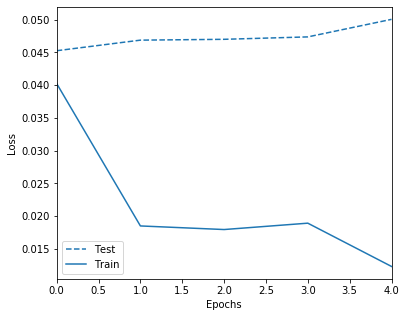

In [29]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(down_X_train,
          pd.get_dummies(down_y_train),
          epochs=5,
          validation_data=(down_X_test, pd.get_dummies(down_y_test))
         )
plot_loss(history)
test_loss, test_acc = model.evaluate(down_X_test, pd.get_dummies(down_y_test))
print('Test accuracy:', test_acc)

In [30]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, down_X_test), columns=['chat'])
result['predict'] = model.predict_proba(down_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)

전체채팅수244, 유해채팅수124


,chat,predict
0,싹둑/Noun 이/Josa =/Punctuation 브베/Noun 미애/Noun =...,0.959285
1,창석/Noun 이/Determiner 붕알/Noun 냄새/Noun 맞고/Verb 파...,0.999989
2,브베/Noun 허/Verb 벌/Noun 창년/Noun <PAD> <PAD> <PAD...,0.999787
3,김영철/Noun 명예훼손/Noun 흑인/Noun 비하/Verb 공무원/Noun 준비...,0.999447
5,이슈/Noun 발년/Noun 아/Josa !/Punctuation 제대로/Noun ...,0.999992
7,오빠/Noun 과자/Noun 를/Josa 몇/Modifier 십분/Noun 을/Jo...,0.999959
10,브베/Noun 야/Josa 차라리/Noun 오락실/Noun 게임/Noun 을/Jos...,0.999986
11,리름/Noun 타는거/Verb 제일/Noun ㅈ/KoreanParticle 같다/A...,0.999242
12,예/Modifier 달/Noun 아/Josa <PAD> <PAD> <PAD> <PA...,0.869845
13,검열/Noun ㅁㅊ/KoreanParticle <PAD> <PAD> <PAD> <P...,0.999883


- 우리는 다양한 비속어 표현에 집중하고 싶고 
- 또한 정확도가 더 높은 downsampling을 사용하자!

In [38]:
result.to_csv('../../data/cnn_result.csv', encoding='euc-kr')

## 분류 애매한 채팅들

In [35]:
result[(result.predict>0.1) & (result.predict<0.9)]

,chat,predict
12,예/Modifier 달/Noun 아/Josa <PAD> <PAD> <PAD> <PA...,0.869845
80,He/Alpha LOVE/Alpha pillow/Alpha He/Alpha LOVE...,0.871644


# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용